In [2]:
pip install opencv-python


   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   -------------- ------------------------- 14.2/38.8 MB 68.4 MB/s eta 0:00:01
   ----------------------------- ---------- 28.6/38.8 MB 67.1 MB/s eta 0:00:01
   ---------------------------------------  38.8/38.8 MB 66.7 MB/s eta 0:00:01
   ---------------------------------------- 38.8/38.8 MB 57.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import libraries
import os # Handeling the file
import pickle #primarily used in serializing and deserializing a Python object structure
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm #used for creating Progress Meters or Progress Bars

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input # preprocess any image to extract the features from image
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # Even out the whole text representaion of features for the remaining length.
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout,add

from nltk.translate.bleu_score import corpus_bleu # Bleu score

import cv2



import pdb #python debugger



import matplotlib.pyplot as plt
from PIL import Image

In [3]:
INPUT_DIR = r'C:\Users\gauta\OneDrive\Desktop\Image-Captioner\Image-captioning\Data'
OUTPUT_DIR = r'C:\Users\gauta\OneDrive\Desktop\Image-Captioner\Image-captioning\Results'

In [4]:
vgg_model = VGG16(weights='imagenet')
# remove the last 2 layers from the model
vgg_model.layers.pop()
vgg_model=Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output) # Dropping last 2 layers

In [5]:
print(vgg_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
# load image data
import glob
path = glob.glob(INPUT_DIR + '/Images/*.jpg')
print(len(path))

31783


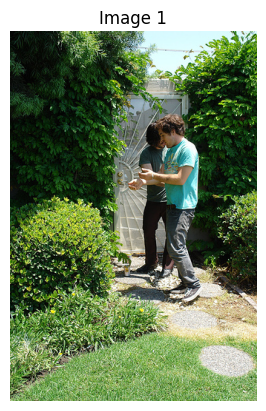

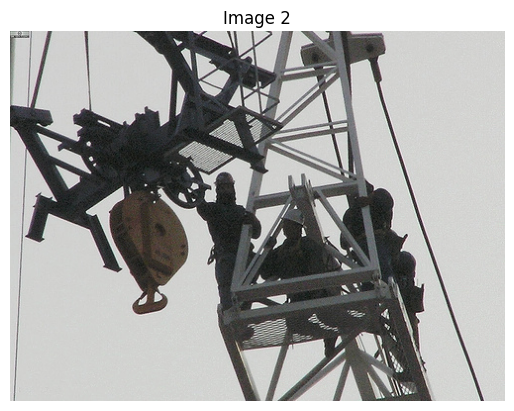

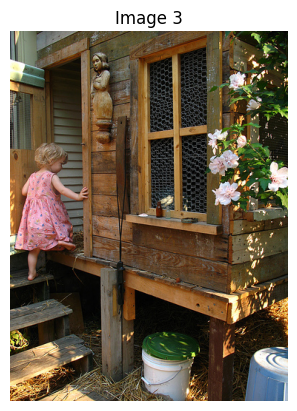

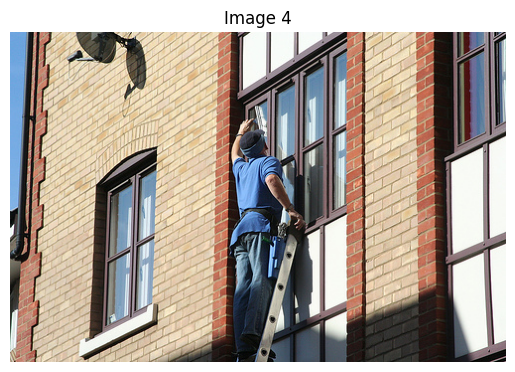

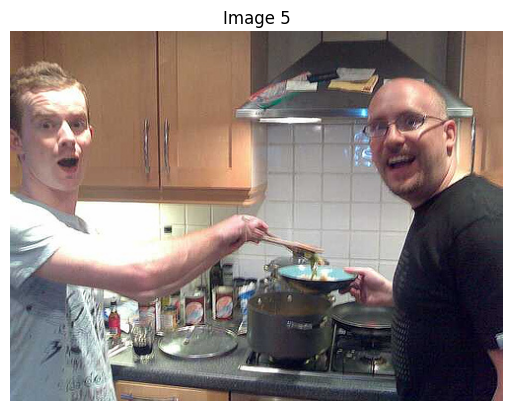

: 

In [ ]:
import cv2
import matplotlib.pyplot as plt

for i in range(min(5, len(path))):
    img = cv2.imread(path[i])
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Could not load image at {path[i]}")
